In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from scipy.stats import pearsonr
from scipy import stats


from statsmodels.stats.outliers_influence import summary_table

from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

#### Для другої частини лабораторної додамо до акцій AMZN акції FedEx та Goldman Sachs

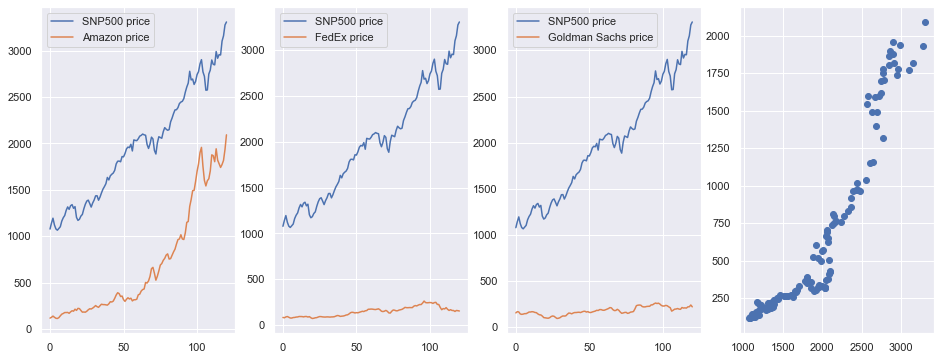

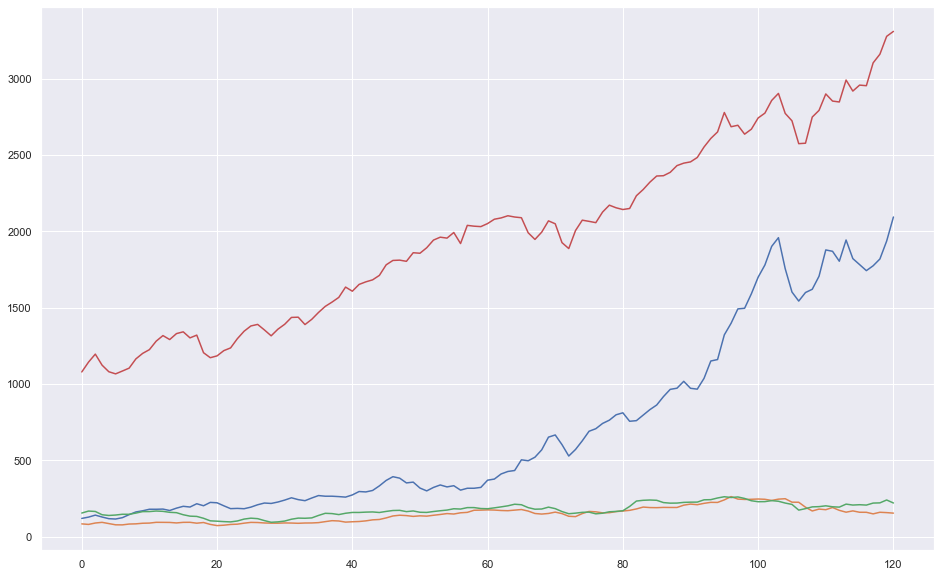

In [2]:
amzn_data = pd.read_csv('../Data/AMZN.csv',parse_dates =['Date'])
snp_data = pd.read_csv('../Data/GSPC.csv',parse_dates=['Date'])

#additional companies as x1,x2
fdx_data = pd.read_csv('../Data/FDX.csv',parse_dates=['Date'])
gs_data = pd.read_csv('../Data/GS.csv',parse_dates=['Date'])

snp_data['Price'] = (snp_data.High + snp_data.Low)*0.5
amzn_data['Price'] = (amzn_data.High + amzn_data.Low)*0.5
fdx_data['Price'] = (fdx_data.High + fdx_data.Low)*0.5
gs_data['Price'] = (gs_data.High + gs_data.Low)*0.5


#please never plot anything like that!
fig, ax = plt.subplots(1,4,figsize=(16,6))

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[0])
amzn_data['Price'].plot(label = 'Amazon price',ax=ax[0])
ax[0].legend()

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[1])
fdx_data['Price'].plot(label = 'FedEx price',ax=ax[1])
ax[1].legend()

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[2])
gs_data['Price'].plot(label = 'Goldman Sachs price',ax=ax[2])
ax[2].legend()

plt.scatter(snp_data['Price'],amzn_data['Price']);

x0,x1,x2,y = amzn_data.Price.values,fdx_data.Price.values,gs_data.Price.values, snp_data['Price'].values
fig =plt.figure(figsize=(16,10))
plt.plot(x0,label='Amazon')
plt.plot(x1,label='FedEx Corp')
plt.plot(x2,label='Goldman Sachs')
plt.plot(y,label='SNP-500')

$ y = b_0 + b_1x $

Завдання1: Перевірка на гетероскедастичність

З переліку галузей, представлених вище, опрацьовуємо запропоновану компанію.
* (A) Використовуючи комп'ютерне програмне забезпечення для виконання регресійних
розрахунків 𝑥 = 𝑟𝑚, 𝑦 = 𝑟𝑝 оцініть за допомогою регресії (1) параметри 𝑏0
і 𝑏1 для компанії.

model coefficients: 
	b0=1323.2274, b1=0.9417,
model characteristics: 
	r=0.9316,R^2=0.8680,F=782.2992


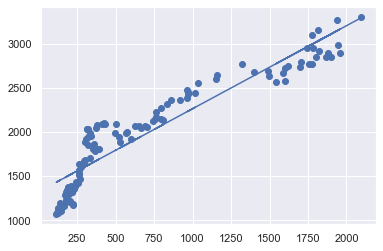

In [3]:
def f_statistic(y,y_pred):
    n=y.shape[0]
    R_2 = r2_score(y,y_pred)
    return (R_2*(n-2))/((1-R_2))


X = x0.reshape(-1,1)

lr = LinearRegression().fit(X,y)
y_hat = lr.predict(X)

b0,b1 = lr.intercept_,lr.coef_[0]
r,r_sq,f_val = pearsonr(y.reshape(-1),y_hat.reshape(-1))[0],r2_score(y,y_hat),f_statistic(y,y_hat)


plt.scatter(X,y)
plt.plot(X,y_hat);
print(f'model coefficients: \n\tb0={b0:.4f}, b1={b1:.4f},\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}')

* (B) Перевірити на гетероскедастичність за допомогою тесту Гольдфелда та Квондта;

In [4]:
f_value,p_val = sms.het_goldfeldquandt(y,X)[0],sms.het_goldfeldquandt(y,X)[1]

f_critical = stats.f.ppf(q=1-0.025,dfn=1, dfd=X.shape[0]-2)
sign,msg = evaluate_hypothesis(f_value,f_critical)

print(f'F_value = {f_value:.4f} {sign} {f_critical:.4f} = F_crit. model is heteroscedastic with p_val={1-p_val}')

F_value = 11.6586 > 5.1534 = F_crit. model is heteroscedastic with p_val=1.0


* (C) Якщо підтвердиться гетероскадастичність трансформувати модель за допомогою
замін:
    * $\sigma^2_{\epsilon_i} = k^2x^2 \Leftrightarrow k^2=\frac{\sigma^2_{\epsilon_i}}{x}$
    * $ \sigma^2_{\epsilon_i} = k^2x \Leftrightarrow k^2=\frac{\sigma^2_{\epsilon_i}}{x}$

1. $\sigma^2_{\epsilon_i} = k^2x^2 \Leftrightarrow k^2=\frac{\sigma^2_{\epsilon_i}}{x}$

In [5]:
y0 = y.reshape(-1)
x = sm.add_constant(x0**(-1))
model = sm.OLS(y0*x0,x).fit()
y_hat = model.predict(x)
model.summary()
b0,b1 = model.params
print(f'model coefficients: \n\tb0={b0:.4f}, b1={b1:.4f}\nmodel characteristics: \n\tr={model.rsquared**0.5:.4f},R^2={model.rsquared:.4f},F={model.fvalue:.4f}')

model coefficients: 
	b0=3582399.8251, b1=-649630862.4511
model characteristics: 
	r=0.7487,R^2=0.5605,F=151.7510


In [6]:
f_value,p_val = sms.het_goldfeldquandt(y,(x0**(-1)).reshape(-1,1))[0],sms.het_goldfeldquandt(y,(x0**(-1)).reshape(-1,1))[1]
sign,msg = evaluate_hypothesis(f_value,f_critical)
print(f'F_value = {f_value:.4f} {sign} {f_critical:.4f} = F_crit. model is not heteroscedastic with p_val={1-p_val}')

F_value = 3.9607 < 5.1534 = F_crit. model is not heteroscedastic with p_val=0.999999836900073


2. $ \sigma^2_{\epsilon_i} = k^2x \Leftrightarrow k^2=\frac{\sigma^2_{\epsilon_i}}{x}$

In [7]:
x = sm.add_constant(x0**(-1/2))
model = sm.OLS(y0*x0,x).fit()
y_hat = model.predict(x)
model.summary()
b0,b1 = model.params

print(f'model coefficients: \n\tb0={b0:.4f}, b1={b1:.4f}\nmodel characteristics: \n\tr={model.rsquared**0.5:.4f},R^2={model.rsquared:.4f},F={model.fvalue:.4f}')

model coefficients: 
	b0=5587022.0370, b1=-77897206.3480
model characteristics: 
	r=0.8443,R^2=0.7129,F=295.4778


In [8]:
f_value,p_val = sms.het_goldfeldquandt(y,(x0**(-1/2)).reshape(-1,1))[0],sms.het_goldfeldquandt(y,(x0**(-1/2)).reshape(-1,1))[1]
sign,msg = evaluate_hypothesis(f_value,f_critical)
print(f'F_value = {f_value:.4f} {sign} {f_critical:.4f} = F_crit. model is not heteroscedastic with p_val={1-p_val}')

F_value = 3.5277 < 5.1534 = F_crit. model is not heteroscedastic with p_val=0.9999987186944147


* (D) Обрати кращу заміну і пояснити чому;<br>
Бачимо, що перша заміна погіршує коеф. детермінації,кореляції та F, друга також погіршує, але не так суттєво. З характеристик моделей робимо висновок, що друга заміна в даному випадку буде кращою

Множинна регресія:
$y = b_0+b_1x_1+b_2x_2+b_3x_3 $

Завдання 2: Перевірка на мультиколінеарність.
З переліку галузей, представлених вище, виберіть одну.
* (E) Використовуючи комп'ютерне програмне забезпечення для виконання регресійних
розрахунків 

𝑦 = 𝑟𝑚, 𝑥1 = 𝑟𝑝; 𝑥2 = 𝑟𝑝+1; 𝑥3 = 𝑟𝑝+2,де 𝑝 + 1 та 𝑝 + 2 компанії яка є наступними після вашої у списку.

Оцініть за допомогою МНК регресію (2) та знайдіть коефіцієнти 𝑏0, 𝑏1, 𝑏2 для компанії.
* (F) Зробіть повний характеристичний аналіз для моделі;
Модель $R^2 |r |F $

In [9]:
X_data,y = np.concatenate([x0.reshape(-1,1),x1.reshape(-1,1),x2.reshape(-1,1)],axis=1), y.reshape(-1,1)

lr = LinearRegression().fit(X_data,y)
b1,b2,b3 = lr.coef_[0]
b0 = lr.intercept_[0]

y_hat = lr.predict(X_data)
r,r_sq,f_val = pearsonr(y.reshape(-1),y_hat.reshape(-1))[0],r2_score(y,y_hat),f_statistic(y,y_hat)
print(f'model coefficients: \n\tb0={b0:.4f}, b1={b1:.4f}, b2={b2:.4f} b3={b3:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}')

model coefficients: 
	b0=707.8392, b1=0.6467, b2=2.5452 b3=2.5549
model characteristics: 
	r=0.9634,R^2=0.9281,F=1535.5362


* (G) Побудувати довірчий діапазон для регресійних значень 𝑦̂ (з рівнем довіри 95%);<br>
Альтернативно побудуємо прогноз за допомогою statsmodels

In [10]:
x = sm.add_constant(X_data)
model = sm.OLS(y,x).fit()
y_hat = model.predict(x)
model.summary()
b0,b1,b2,b3 = model.params
print(f'model coefficients: \n\tb0={b0:.4f}, b1={b1:.4f}, b2={b2:.4f} b3={b3:.4f}\nmodel characteristics: \n\tr={model.rsquared**0.5:.4f},R^2={model.rsquared:.4f},F={model.fvalue:.4f}')

model coefficients: 
	b0=707.8392, b1=0.6467, b2=2.5452 b3=2.5549
model characteristics: 
	r=0.9634,R^2=0.9281,F=503.2430


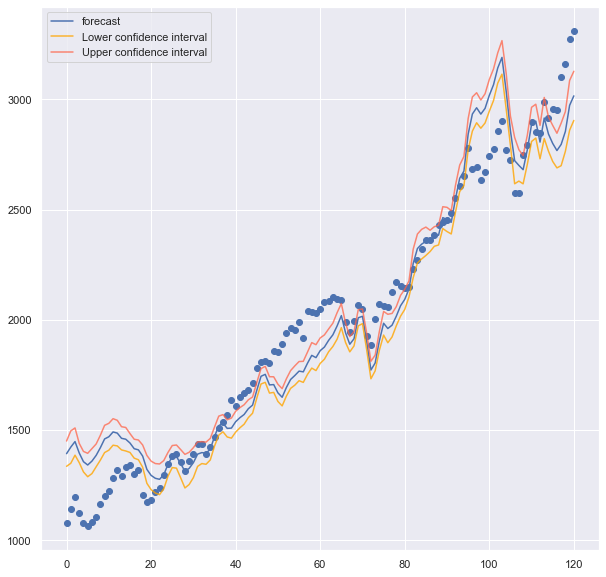

In [11]:
ci_lower, ci_upper = summary_table(model, alpha = 0.05)[1][:, 4:6].T

plt.figure(figsize=(10,10))

plt.plot(np.arange(121),y_hat,label='forecast')
plt.scatter(np.arange(121),y)

plt.plot(np.arange(121), ci_lower,alpha=0.8,color='orange',label='Lower confidence interval')
plt.plot(np.arange(121), ci_upper,alpha=0.75,c='tomato',label='Upper confidence interval')
# plt.fill_between(snp_test_data.Price,forecast_ci['low'],forecast_ci['high'],alpha=0.2)
plt.legend();

* (H) Перевірте на наявність мультиколінеарності;
* (I) Якщо мультиколінеарність підтверджується змініть модель;

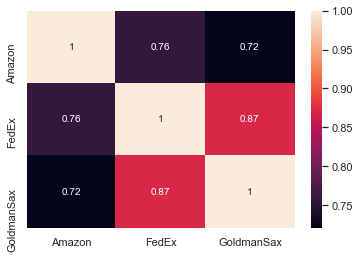

In [12]:
t = pd.DataFrame(X_data,columns=['Amazon','FedEx','GoldmanSax'])
sns.heatmap(t.corr(),annot=True);

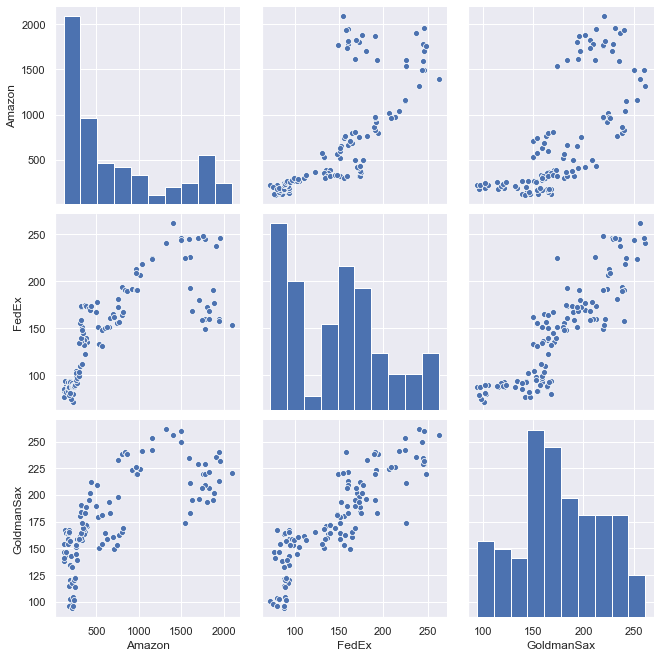

In [13]:
sns.pairplot(t,palette='tab20',height=3);

Перевірка на мультиколінеарність: [Variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor)

In [14]:
cc = np.corrcoef(t, rowvar=False)
VIF = np.linalg.inv(cc)
VIF.diagonal()

array([2.4355358 , 4.92351239, 4.34704031])

In [15]:
print('Не можемо підтвердити сильну мультиколінеарність, не будемо змінювати модель' if VIF.max()<10 else 'Бачимо високу мультиколінеарність, маємо змінювати модель')

Не можемо підтвердити сильну мультиколінеарність, не будемо змінювати модель
